# Nonstretch NMO

This notebook implements nonstretch NMO as described in:

Perroud, H., & Tygel, M. (2004). Nonstretch NMO. Geophysics, 69(2), 599–607. https://doi.org/10.1190/1.1707080

In [1]:
from math import floor, ceil

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import ImageGrid, make_axes_locatable
from numba import jit, prange
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter

from pylops import LinearOperator
from pylops.optimization import sparsity
from pylops.utils import dottest
from pylops.utils.seismicevents import hyperbolic2d, makeaxis
from pylops.utils.wavelets import ricker


def create_colorbar(im, ax):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cb = fig.colorbar(im, cax=cax, orientation="vertical")
    return cax, cb


In [2]:
par = dict(ox=0, dx=40, nx=160, ot=0, dt=0.004, nt=1020)
t, _, x, _ = makeaxis(par)

t0s_true = np.array([0.5, 1.22, 1.65])
vrms_true = np.array([2000.0, 2400.0, 2500.0])
amps = np.array([1, 0.2, 0.5])

freq = 10  # Hz
wav, *_ = ricker(t[:41], f0=freq)

_, data = hyperbolic2d(x, t, t0s_true, vrms_true, amp=amps, wav=wav)

np.random.seed(0)
data_clean = data.copy()
data += 0.5 * np.random.randn(*data.shape)


In [3]:
def nmo_moveout(t0, vnmo, offset):
    return np.sqrt(t0 ** 2 + (offset / vnmo) ** 2)


def nonstretch_vnmo(tau, t0, vnmo, offset):
    a = offset / (t0 * vnmo)
    denom = np.sqrt(1 + 2 * tau / (t0 * (1 + np.sqrt(1 + a ** 2))))
    return vnmo / denom


In [4]:
# Offset-dependent traveltime of the first hyperbolic event
t_nmo_ev1 = nmo_moveout(t0s_true[0], vrms_true[0], x)

# Nonstretch at t0
tau = 0.0
vnmo_ns = nonstretch_vnmo(tau, t0s_true[0], vrms_true[0], x)
t_nmo_ev1_ns = nmo_moveout(t0s_true[0], vnmo_ns, x)


In [5]:
# Suppose we have an event that is 150 ms after t0
tau = 0.15
t_nmo_tau = nmo_moveout(t0s_true[0] + tau, vrms_true[0], x)

vnmo_ns = nonstretch_vnmo(tau, t0s_true[0], vrms_true[0], x)
t_nmo_tau_ns = nmo_moveout(t0s_true[0] + tau, vnmo_ns, x)


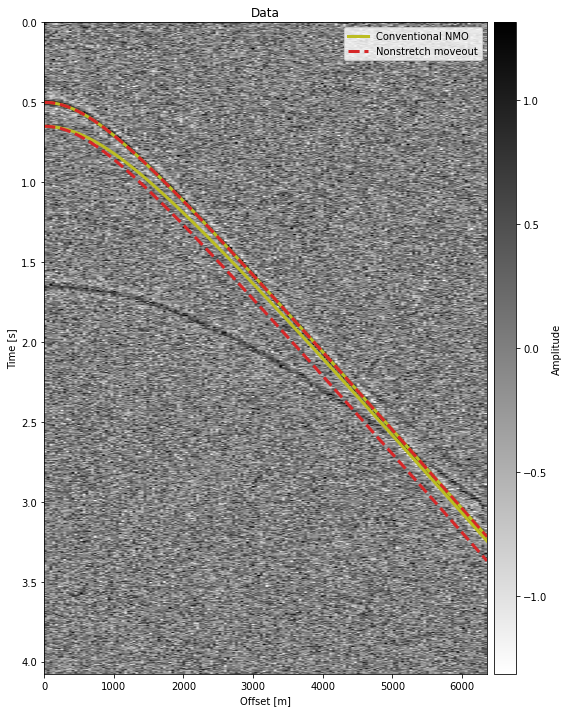

In [6]:
pclip = 0.5
dmax = np.max(np.abs(data))
opts = dict(
    cmap="gray_r",
    extent=[x[0], x[-1], t[-1], t[0]],
    aspect="auto",
    vmin=-pclip * dmax,
    vmax=pclip * dmax,
)

fig, ax = plt.subplots(figsize=(8, 10))
vmax = np.max(np.abs(data))
im = ax.imshow(data.T, **opts)
ax.plot(x, t_nmo_ev1, "C8", lw=3, label="Conventional NMO")
ax.plot(x, t_nmo_ev1_ns, "C3--", lw=3, label="Nonstretch moveout")
ax.plot(x, t_nmo_tau, "C8", lw=3)
ax.plot(x, t_nmo_tau_ns, "C3--", lw=3)
ax.set(title="Data", xlabel="Offset [m]", ylabel="Time [s]")
cax, _ = create_colorbar(im, ax)
cax.set_ylabel("Amplitude")
ax.legend()
fig.tight_layout()


In [7]:
class NonstretchNMO(LinearOperator):
    def __init__(
        self,
        taxis,
        haxis,
        t0_picks,
        vrms_picks,
        wavelet_halfwidth,
        interpolation_method="linear",
        smooth=None,
        dtype=None,
    ):
        self._taxis = taxis
        self._haxis = haxis
        self._t0_picks = t0_picks
        self._vrms_picks = vrms_picks
        self._wavelet_halfwidth = wavelet_halfwidth
        self._interpolation_method = interpolation_method
        self._smooth = smooth
        self.dims = (len(haxis), len(taxis))

        # Required LinearOperator attributes
        self.explicit = False
        self.shape = (np.prod(self.dims),) * 2
        argdtypes = np.result_type(taxis.dtype, haxis.dtype)
        self.dtype = argdtypes if dtype is None else dtype
        self.clinear = False

        # Create nonstretch NMO
        dt = self._taxis[1] - self._taxis[0]
        winlen = ceil(self._wavelet_halfwidth / dt)
        twin = dt * np.arange(-winlen, winlen + 1)

        self._vnmo = NonstretchNMO._create_nonstretch_nmo(
            self._t0_picks,
            self._vrms_picks,
            self._taxis,
            self._haxis,
            twin,
            interpolation_method=self._interpolation_method,
            smooth=self._smooth,
            dtype=self.dtype,
        )
        self._register_forward_adjoint()

    @staticmethod
    def _nonstretch_vnmo(t0, offset, vnmo, tau):
        a = offset / (t0 * vnmo)
        denom = np.sqrt(1 + 2 * tau / (t0 * (1 + np.sqrt(1 + a ** 2))))
        return vnmo / denom

    @staticmethod
    def _compute_vtau_for_interp(t0_picks, vrms_picks, offset, twin):
        points = []
        values = []
        for t0, vnmo in zip(t0_picks, vrms_picks):
            for tau in twin:
                vtau = NonstretchNMO._nonstretch_vnmo(t0, offset, vnmo, tau)
                points += [t0 + tau]
                values += [vtau]
        return points, values

    @staticmethod
    def _interpolate_vrms(t0_picks, vrms_picks, taxis, method="linear", smooth=None):
        assert len(t0_picks) == len(vrms_picks)

        # Sampled points in time axis
        points = np.zeros((len(t0_picks) + 2,))
        points[0] = taxis[0]
        points[-1] = taxis[-1]
        points[1:-1] = t0_picks

        # Sampled values of slowness (in s/km)
        values = np.zeros((len(vrms_picks) + 2,))
        values[0] = 1000.0 / vrms_picks[0]  # Use first slowness before t0_picks[0]
        values[-1] = 1000.0 / vrms_picks[-1]  # Use the last slowness after t0_picks[-1]
        values[1:-1] = 1000.0 / np.array(vrms_picks)

        slowness = griddata(points, values, taxis, method=method)
        if smooth is not None:
            slowness = gaussian_filter(slowness, sigma=smooth)

        return 1000.0 / slowness

    @staticmethod
    def _create_nonstretch_nmo(
        t0_picks,
        vrms_picks,
        taxis,
        haxis,
        twin,
        interpolation_method="linear",
        smooth=None,
        dtype=None,
    ):
        dims = (len(haxis), len(taxis))
        vnmo_ns = np.zeros(dims, dtype=dtype)
        for ih, h in enumerate(haxis):
            pts, vals = NonstretchNMO._compute_vtau_for_interp(
                t0_picks, vrms_picks, h, twin
            )
            vnmo_ns[ih, :] = NonstretchNMO._interpolate_vrms(
                pts, vals, taxis, method=interpolation_method, smooth=smooth
            )
        return vnmo_ns

    def _register_forward_adjoint(self):
        taxis, haxis, vels_rms = self._taxis, self._haxis, self._vnmo
        dt = taxis[1] - taxis[0]
        ot = taxis[0]
        nt = len(taxis)
        nh = len(haxis)

        @jit(nopython=True, fastmath=True, nogil=True, parallel=True)
        def _nmo_forward(data):
            dnmo = np.zeros_like(data)
            # Parallel outer loop on slow axis
            for ih in prange(nh):
                for it0 in range(nt):
                    # Compute NMO traveltime
                    tx = np.sqrt(taxis[it0] ** 2 + (haxis[ih] / vels_rms[ih, it0]) ** 2)
                    it_frac = (tx - ot) / dt  # Fractional index
                    it_floor = floor(it_frac)
                    it_ceil = it_floor + 1
                    w = it_frac - it_floor
                    if 0 <= it_floor and it_ceil < nt:
                        dnmo[ih, it0] += (1 - w) * data[ih, it_floor] + w * data[
                            ih, it_ceil
                        ]
            return dnmo

        @jit(nopython=True, fastmath=True, nogil=True, parallel=True)
        def _nmo_adjoint(dnmo):
            data = np.zeros_like(dnmo)
            # Parallel outer loop on slow axis; use range if Numba is not installed
            for ih in prange(nh):
                for it0 in range(nt):
                    # Compute NMO traveltime
                    tx = np.sqrt(taxis[it0] ** 2 + (haxis[ih] / vels_rms[ih, it0]) ** 2)
                    it_frac = (tx - ot) / dt  # Fractional index
                    it_floor = floor(it_frac)
                    it_ceil = it_floor + 1
                    w = it_frac - it_floor
                    if 0 <= it_floor and it_ceil < nt:
                        data[ih, it_floor] += (1 - w) * dnmo[ih, it0]
                        data[ih, it_ceil] += w * dnmo[ih, it0]
            return data

        self._nmo_forward = _nmo_forward
        self._nmo_adjoint = _nmo_adjoint

    def _matvec(self, x):
        x = x.reshape(self.dims)
        y = self._nmo_forward(x)
        y = y.ravel()
        return y

    def _rmatvec(self, y):
        y = y.reshape(self.dims)
        x = self._nmo_adjoint(y)
        x = x.ravel()
        return x


In [8]:
wavelet_halfwidth = 2 * np.sqrt(3) / (np.pi * freq)
N = NonstretchNMO(
    t,
    x,
    t0s_true,
    vrms_true,
    wavelet_halfwidth,
    interpolation_method="nearest",
    smooth=5,
)


In [9]:
dottest(N)

True

In [10]:
vnmo_stretch = NonstretchNMO._interpolate_vrms(t0s_true, vrms_true, t)
vnmo_nonstretch = N._vnmo

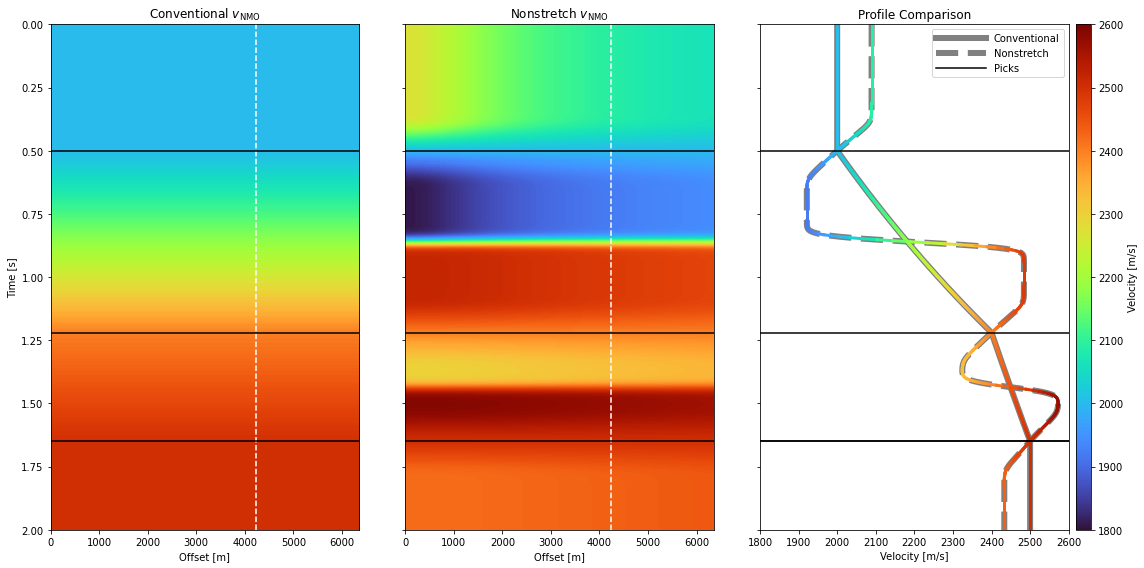

In [11]:
# Plot stretch and nonstretch
vmin = 100 * (min(np.min(vnmo_stretch), np.min(vnmo_nonstretch)) // 100)
vmax = 100 * ((max(np.max(vnmo_stretch), np.max(vnmo_nonstretch)) + 99) // 100)
opts_vels = dict(
    cmap="turbo",
    extent=[x[0], x[-1], t[-1], t[0]],
    aspect="auto",
    interpolation="none",
    vmin=vmin,
    vmax=vmax,
)

ih = 2 * par["nx"] // 3
fig, axs = plt.subplots(1, 3, figsize=(16, 8), sharey=True)
im = axs[0].imshow(vnmo_stretch[np.newaxis, :].T, **opts_vels)
axs[0].axvline(x[ih], color="w", linestyle="--")
divider = make_axes_locatable(axs[0])
cax = divider.append_axes("right", size="5%", pad=0.1)
cax.axis("off")

axs[1].imshow(vnmo_nonstretch.T, **opts_vels)
axs[1].axvline(x[ih], color="w", linestyle="--")
divider = make_axes_locatable(axs[1])
cax = divider.append_axes("right", size="5%", pad=0.1)
cax.axis("off")

axs[2].plot(vnmo_stretch, t, color="gray", lw=6, label=r"Conventional", zorder=-1)
axs[2].plot(
    vnmo_nonstretch[ih, :], t, "--", color="gray", lw=6, label=r"Nonstretch", zorder=-1
)
cmap = plt.cm.get_cmap(opts_vels["cmap"])
for i in np.arange(len(t) - 1):
    c = cmap((vnmo_stretch[i] - vmin) / (vmax - vmin))
    axs[2].plot([vnmo_stretch[i], vnmo_stretch[i + 1]], [t[i], t[i + 1]], c=c, lw=3)
    c = cmap((vnmo_nonstretch[ih, i] - vmin) / (vmax - vmin))
    axs[2].plot(
        [vnmo_nonstretch[ih, i], vnmo_nonstretch[ih, i + 1]],
        [t[i], t[i + 1]],
        c=c,
        lw=3,
    )

cax, _ = create_colorbar(im, axs[2])
cax.set_ylabel("Velocity [m/s]")

for ax in axs:
    for t0 in t0s_true:
        ax.axhline(t0, color="k")
axs[2].axhline(t0s_true[-1], color="k", label="Picks")

axs[0].set(
    xlabel="Offset [m]",
    ylabel="Time [s]",
    ylim=[t[-1] // 2, t[0]],
    title=r"Conventional $v_\mathrm{NMO}$",
)
axs[1].set(xlabel="Offset [m]", title=r"Nonstretch $v_\mathrm{NMO}$")
axs[2].set(xlabel="Velocity [m/s]", xlim=[vmin, vmax], title=r"Profile Comparison")
axs[2].legend(handlelength=5)

fig.tight_layout()


In [12]:
dnmo = (N @ data.ravel()).reshape(N.dims)

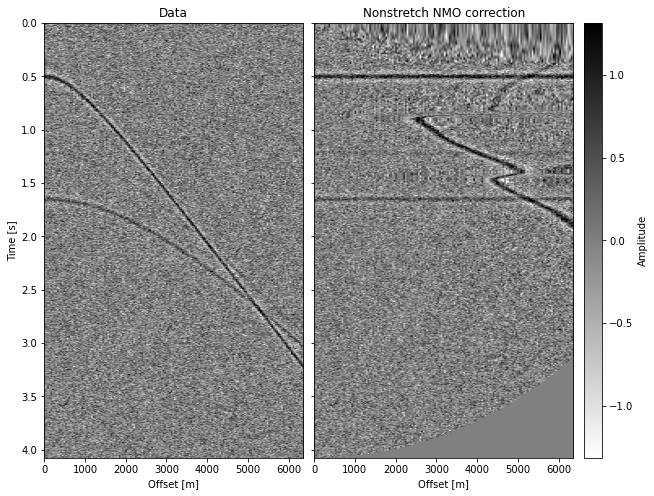

In [13]:
###############################################################################

# Plot Data and NMO-corrected data
fig = plt.figure(figsize=(10, 8))
grid = ImageGrid(
    fig,
    111,
    nrows_ncols=(1, 2),
    axes_pad=0.15,
    cbar_location="right",
    cbar_mode="single",
    cbar_size="7%",
    cbar_pad=0.15,
    aspect=False,
    share_all=True,
)
im = grid[0].imshow(data.T, **opts)
grid[0].set(title="Data", xlabel="Offset [m]", ylabel="Time [s]")
grid[0].cax.colorbar(im)
grid[0].cax.set_ylabel("Amplitude")

grid[1].imshow(dnmo.T, **opts)
grid[1].set(title="Nonstretch NMO correction", xlabel="Offset [m]")
plt.show()


In [14]:
trace_zoff = data[0, :]
trace_zoff_clean = data_clean[0,:]
trace_stack = np.mean(dnmo, axis=0)


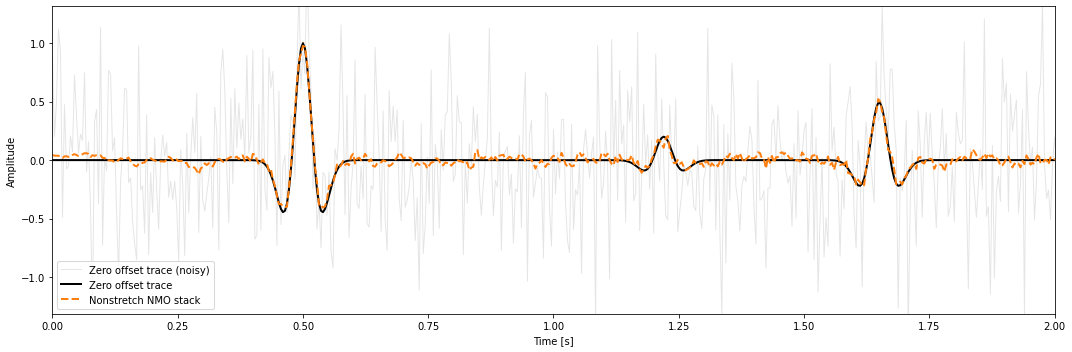

In [15]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(t, trace_zoff, "k", alpha=0.1, lw=1, label=r"Zero offset trace (noisy)")
ax.plot(t, trace_zoff_clean, "k", lw=2, label=r"Zero offset trace")
ax.plot(t, trace_stack, "C1--", lw=2, label="Nonstretch NMO stack")
ax.set(
    xlabel="Time [s]",
    ylabel="Amplitude",
    xlim=[t[0], 2],
    ylim=[opts["vmin"], opts["vmax"]],
)
ax.legend()
fig.tight_layout()


In [16]:
from pylops.signalprocessing import ChirpRadon2D

pmax = 1 / np.min(vrms_true)  # s/m
R = ChirpRadon2D(t, x, pmax * par["dx"] / par["dt"])

dnmo_ns_r = (R @ dnmo.ravel()).reshape(data.shape)


In [17]:
p = 1e3 * np.linspace(-pmax, pmax, par["nx"])  # s/km


In [18]:
taper = np.ones(par["nx"])
ptaplow, ptaphigh = 0.02, 0.05

taper[(-ptaphigh > p) | (p > ptaphigh)] = 0.0
taplen = len(taper[(ptaplow < p) & (p < ptaphigh)])
costap = 0.5 * np.cos(np.linspace(0, 1, taplen) * np.pi) + 0.5
taper[(ptaplow < p) & (p < ptaphigh)] = costap
taper[(-ptaplow > p) & (p > -ptaphigh)] = 1 - costap
taper = taper[:, np.newaxis]

from pylops.basicoperators import Diagonal

M = Diagonal(taper.ravel(), dims=data.shape, dir=0)

dnmo_ns_r_filt = (M * dnmo_ns_r.ravel()).reshape(data.shape)


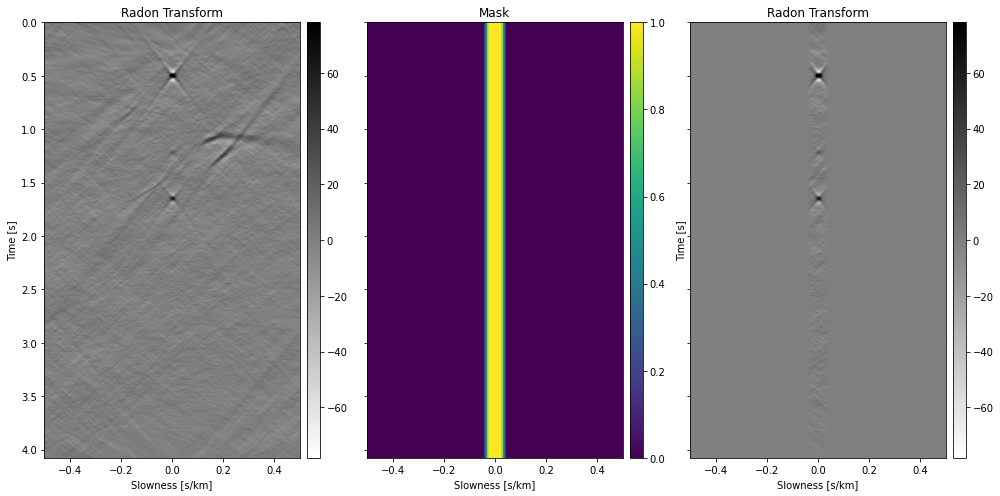

In [19]:
vmax = np.max(np.abs(dnmo_ns_r))
opts_radon = {
    **opts,
    **dict(extent=[p[0], p[-1], t[-1], t[0]], vmin=-pclip * vmax, vmax=pclip * vmax),
}

fig, axs = plt.subplots(1, 3, figsize=(14, 7), sharex=True, sharey=True)
im = axs[0].imshow(dnmo_ns_r.T, **opts_radon)
axs[0].set(title="Radon Transform", xlabel="Slowness [s/km]", ylabel="Time [s]")
cax, _ = create_colorbar(im, axs[0])

im = axs[1].imshow(taper.T, extent=[p[0], p[-1], t[-1], t[0]], aspect="auto")
cax, _ = create_colorbar(im, axs[1])
axs[1].set(title="Mask", xlabel="Slowness [s/km]")

im = axs[2].imshow(dnmo_ns_r_filt.T, **opts_radon)
axs[2].set(title="Radon Transform", xlabel="Slowness [s/km]", ylabel="Time [s]")
cax, _ = create_colorbar(im, axs[2])


fig.tight_layout()


In [20]:
dnmo_ns_filt = (R.inverse((taper * dnmo_ns_r).ravel())).reshape(data.shape)


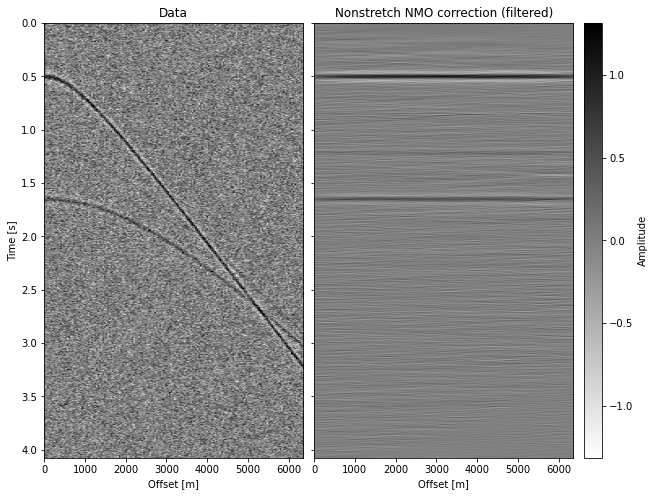

In [21]:
###############################################################################

# Plot Data and NMO-corrected data
fig = plt.figure(figsize=(10, 8))
grid = ImageGrid(
    fig,
    111,
    nrows_ncols=(1, 2),
    axes_pad=0.15,
    cbar_location="right",
    cbar_mode="single",
    cbar_size="7%",
    cbar_pad=0.15,
    aspect=False,
    share_all=True,
)
im = grid[0].imshow(data.T, **opts)
grid[0].set(title="Data", xlabel="Offset [m]", ylabel="Time [s]")
grid[0].cax.colorbar(im)
grid[0].cax.set_ylabel("Amplitude")

grid[1].imshow(dnmo_ns_filt.T, **opts)
grid[1].set(title="Nonstretch NMO correction (filtered)", xlabel="Offset [m]")

plt.show()


In [22]:
trace_stack_filt = np.mean(dnmo_ns_filt, axis=0)

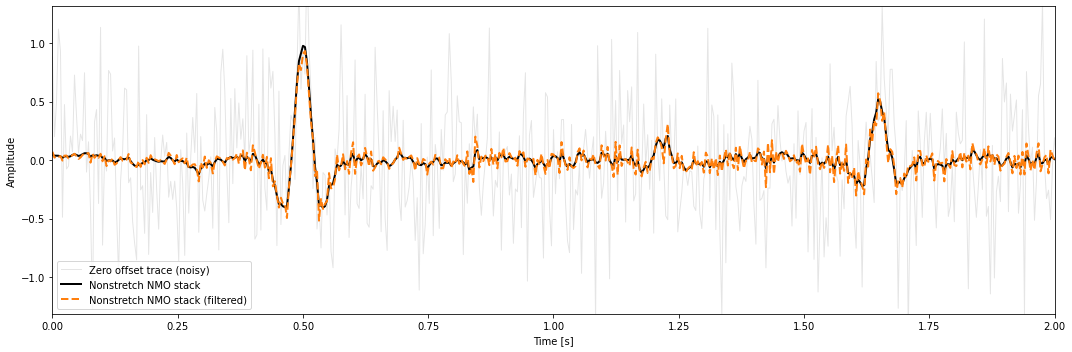

In [23]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(t, trace_zoff, "k", alpha=0.1, lw=1, label=r"Zero offset trace (noisy)")
ax.plot(t, trace_stack, "k", lw=2, label=r"Nonstretch NMO stack")
ax.plot(t, trace_stack_filt, "C1--", lw=2, label="Nonstretch NMO stack (filtered)")
ax.set(
    xlabel="Time [s]",
    ylabel="Amplitude",
    xlim=[t[0], 2],
    ylim=[opts["vmin"], opts["vmax"]],
)
ax.legend()
fig.tight_layout()


In [24]:
xinv, niter, cost = sparsity.FISTA(
    R.H @ M,
    # R.H,
    dnmo.ravel(),
    150,
    eps=10,
    returninfo=True,
)
xinv = xinv.reshape(dnmo.shape)

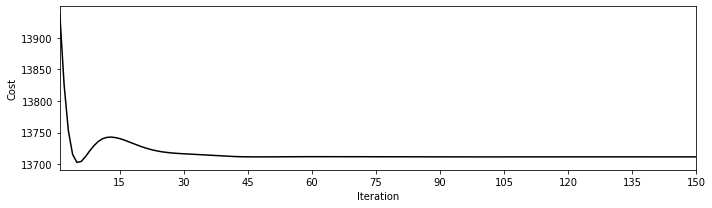

In [25]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(range(1, niter+1), cost, "k")
ax.set(xlabel="Iteration", ylabel="Cost", xlim=[1, niter])
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
fig.tight_layout()

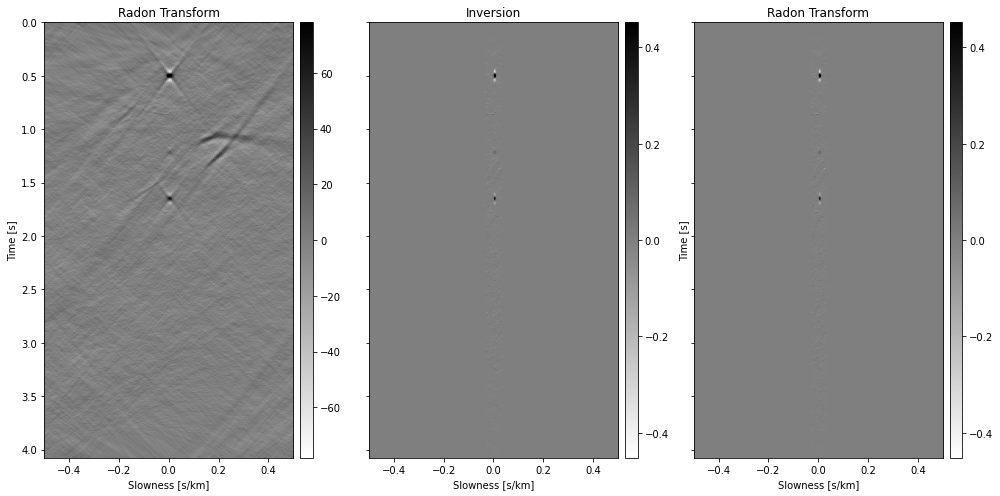

In [26]:
vmax = np.max(np.abs(dnmo_ns_r))
opts_radon = {
    **opts,
    **dict(extent=[p[0], p[-1], t[-1], t[0]], vmin=-pclip * vmax, vmax=pclip * vmax),
}

fig, axs = plt.subplots(1, 3, figsize=(14, 7), sharex=True, sharey=True)
im = axs[0].imshow(dnmo_ns_r.T, **opts_radon)
axs[0].set(title="Radon Transform", xlabel="Slowness [s/km]", ylabel="Time [s]")
cax, _ = create_colorbar(im, axs[0])

vmax = np.max(np.abs(xinv))
opts_radon = {
    **opts_radon,
    **dict(vmin=-pclip * vmax, vmax=pclip * vmax),
}
im = axs[1].imshow(xinv.T, **opts_radon)
cax, _ = create_colorbar(im, axs[1])
axs[1].set(title="Inversion", xlabel="Slowness [s/km]")

im = axs[2].imshow((M @ xinv.ravel()).reshape(data.shape).T, **opts_radon)
axs[2].set(title="Radon Transform", xlabel="Slowness [s/km]", ylabel="Time [s]")
cax, _ = create_colorbar(im, axs[2])


fig.tight_layout()


In [27]:
dnmo_ns_filt_sparse = (R.H @ M @ xinv.ravel()).reshape(data.shape)
# dnmo_ns_filt_sparse = (R.H @ xinv.ravel()).reshape(data.shape)


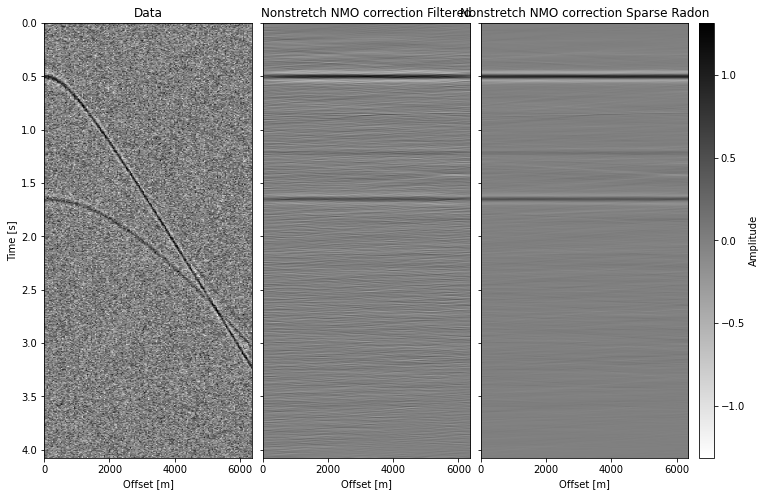

In [28]:
###############################################################################

# Plot Data and NMO-corrected data
fig = plt.figure(figsize=(12, 8))
grid = ImageGrid(
    fig,
    111,
    nrows_ncols=(1, 3),
    axes_pad=0.15,
    cbar_location="right",
    cbar_mode="single",
    cbar_size="7%",
    cbar_pad=0.15,
    aspect=False,
    share_all=True,
)
im = grid[0].imshow(data.T, **opts)
grid[0].set(title="Data", xlabel="Offset [m]", ylabel="Time [s]")
grid[0].cax.colorbar(im)
grid[0].cax.set_ylabel("Amplitude")

grid[1].imshow(dnmo_ns_filt.T, **opts)
grid[1].set(title="Nonstretch NMO correction Filtered", xlabel="Offset [m]")

grid[2].imshow(dnmo_ns_filt_sparse.T, **opts)
grid[2].set(title="Nonstretch NMO correction Sparse Radon", xlabel="Offset [m]")
plt.show()


In [29]:
trace_stack_filt_sp = np.mean(dnmo_ns_filt_sparse, axis=0)


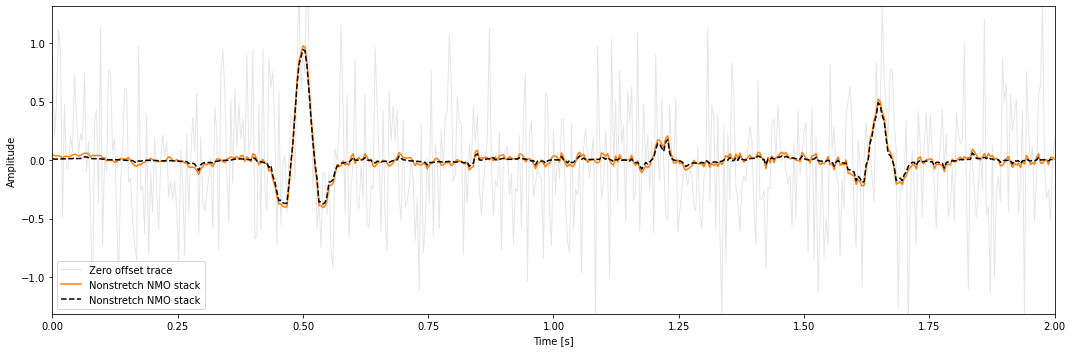

In [30]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(t, trace_zoff, "k", alpha=0.1, lw=1, label=r"Zero offset trace")
ax.plot(t, trace_stack, "C1", label="Nonstretch NMO stack")
ax.plot(t, trace_stack_filt_sp, "k--", label="Nonstretch NMO stack")
ax.set(
    xlabel="Time [s]",
    ylabel="Amplitude",
    xlim=[t[0], 2],
    ylim=[opts["vmin"], opts["vmax"]],
)
ax.legend()
fig.tight_layout()
